## This notebook explores q-learned policies:

In [4]:
import sys
import os 
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../../..')

from learning.collections_env.collections_env import CollectionsEnv, MAX_ACCOUNT_BALANCE
from learning.utils.wrappers import DiscretizedActionWrapper, StateNormalization
from learning.policies.dqn import DQNAgent, DefaultConfig
from learning.utils import misc
from dcc import Parameters, AAV, OAV


import os
import numpy as np
import pickle
import copy
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K

import tensorflow_lattice as tfl

from IPython.display import HTML, clear_output

import matplotlib.pyplot as plt
import seaborn as sns

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"



In [5]:
name = 'DDQN_10K'
log_path = os.path.join(misc.RESOURCE_ROOT, 'models', name)
logs = os.listdir(log_path)
logs

['20200727-130319',
 '20200727-170857',
 '20200727-211222',
 '20200728-101029',
 '20200728-174759',
 '20200729-100525',
 '20200729-175032']

In [6]:
def construct_paths(log_num):
    models = os.listdir(os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num]))
    model_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num])
    env_path =  os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'env.pkl')
    try:
        buffer_path = os.path.join(misc.RESOURCE_ROOT, 'models', name, logs[log_num], 'buffer.pkl')
    except:
        print('No buffer found.')

    with open(buffer_path,'rb') as f:
        buffer = pickle.load(f)
    return model_path, buffer

model_path, buffer = construct_paths(-1)
os.listdir(model_path)

['buffer.pkl', 'env.pkl', 'main_net.h5', 'train_config.pkl']

In [7]:
agent = DQNAgent.load(model_path)
agent.main_net.compile(loss='MSE')

[WARNING] [2020-07-30 10:30:37,300] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 10:30:37,389] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [64]:
def create_map(agent, lam_lim=7):
    w_points = 80
    l_points = 80
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    w_normalized = np.linspace(0, 1, w_points)
    l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
    wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(w_normalized):
        for j, yp in enumerate(l_normalized):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.amax(agent.main_net.predict_on_batch(fixed_obs[None, :]))
            p[j, i] = agent.env.action(np.argmax(agent.main_net.predict_on_batch(fixed_obs[None,:])))
    return ww, ll, p, z
ww, ll, aa, z = create_map(agent)

Text(0.5, 1.0, 'Simplest default with labels')

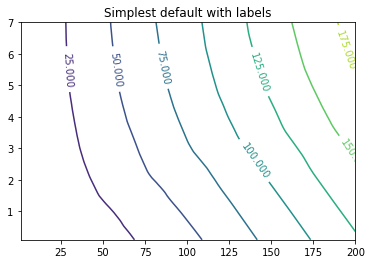

In [9]:
fig, ax = plt.subplots()
CS = ax.contour(ww, ll, z)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Simplest default with labels')

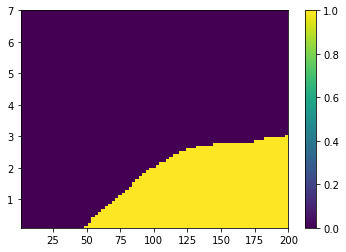

In [10]:
plt.pcolor(ww, ll, aa)
plt.colorbar()
plt.show()

In [117]:
def evaluate_agent(agent, s0=np.array([0.11, 200]), n=500, aav=False):
    # Construct the environment
    environment = CollectionsEnv(w0=agent.env.w0, params=agent.env.params, reward_shaping='discrete', randomize_start=False, starting_state=s0)
    environment = StateNormalization(environment=environment)
    rewards = []
    w_states = []
    l_states = []
    actions = []
    for i in range(n):
        episode_reward = 0
        done = False
        state = environment.reset()
        while not done:
            # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
            if aav:
                action = 0.0
            else:
                action, q = agent.get_action(state, epsilon=0.0)
            # action = 0
            actions.append(action)
            state, reward, done, _ = environment.step(action)
            episode_reward += reward
            converted_state = environment.convert_back(state)
            # w_states.append(converted_state[1])
            # l_states.append(converted_state[0])
            if episode_reward>200:
                break
            if done:
                rewards.append(episode_reward)
    return rewards

Construct value function in (lambda, w) space

In [168]:
from tqdm import tqdm

def true_value(agent, lam_lim):
    w_points = 30
    l_points = 30
    l = np.linspace(agent.env.observation_space.low[0], lam_lim, l_points)
    w = np.linspace(agent.env.observation_space.low[1], agent.env.observation_space.high[1], w_points)
    w_normalized = np.linspace(0, 1, w_points)
    l_normalized = np.linspace(0, agent.env.observation((lam_lim,100))[0], l_points)
    wwn, lln = np.meshgrid(w_normalized, l_normalized)
    ww, ll = np.meshgrid(w, l)
    z = np.zeros_like(ww)
    p = np.zeros_like(ww)
    for i, xp in enumerate(tqdm(w_normalized)):
        for j, yp in enumerate(l_normalized):
            fixed_obs = np.array([yp, xp])
            z[j, i] = np.mean(evaluate_agent(agent, s0=np.array([l[j], w[i]]), n=500))
    return ww, ll, z

www, lll, zz = true_value(agent, lam_lim=7)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [26:48:30<00:00, 3217.02s/it]


In [159]:
zz = np.load('z.npy')

In [160]:
www = np.load('www.npy')

In [161]:
lll = np.load('lll.npy')

[INFO] [2020-07-30 13:05:48,415] [AAV] - Instantiated @ AAV
[INFO] [2020-07-30 13:05:48,428] [OAV] - Launching the value function procedure.
[INFO] [2020-07-30 13:05:48,428] [OAV] - Computing the value function on (0.00, 63.99].
[INFO] [2020-07-30 13:05:48,443] [OAV] - Computing the value function on (63.99, 71.10].
[INFO] [2020-07-30 13:05:50,257] [OAV] - Computing the value function on (71.10, 79.00].
[INFO] [2020-07-30 13:05:51,552] [OAV] - Computing the value function on (79.00, 87.78].
[INFO] [2020-07-30 13:05:52,513] [OAV] - Computing the value function on (87.78, 97.53].
[INFO] [2020-07-30 13:05:53,684] [OAV] - Computing the value function on (97.53, 108.37].
[INFO] [2020-07-30 13:05:54,856] [OAV] - Computing the value function on (108.37, 120.41].
[INFO] [2020-07-30 13:05:56,202] [OAV] - Computing the value function on (120.41, 133.79].
[INFO] [2020-07-30 13:05:57,694] [OAV] - Computing the value function on (133.79, 148.65].
[INFO] [2020-07-30 13:05:59,270] [OAV] - Computing t

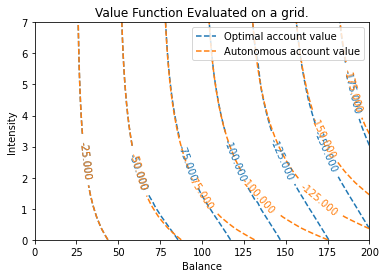

In [162]:
oav = OAV(agent.env.params, agent.env.w0, lmax=7)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

In [163]:
CS = ax.contour(www, lll, -zz)
ax.clabel(CS, inline=1, fontsize=10)
ax.set_title('Value function')

Text(0.5, 1.0, 'Value function')

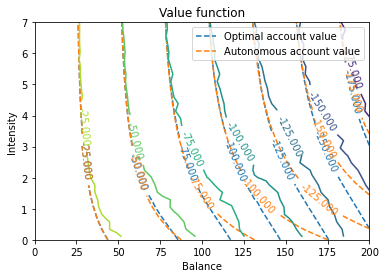

In [164]:
fig

Comparison on montecarlo value with 200 evaluations per point

In [27]:
def get_frontier(ww, ll, aa):
    w_vector = ww[1, :]
    l_vector = ll[:, 1]
    lstars = np.zeros_like(w_vector)
    for i, w in enumerate(w_vector):
        try:
            l_star_index = np.max(np.nonzero(aa[:, i]))
            l_star = l_vector[l_star_index]
            lstars[i] = l_star
        except:
            lstars[i] = 0.0
    return w_vector, lstars

w_front, l_front = get_frontier(ww, ll, aa)

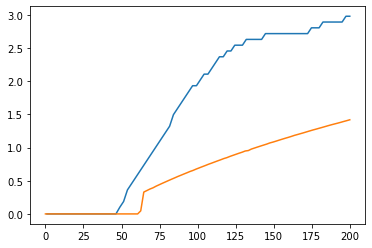

In [29]:
plt.plot(w_front, l_front)
plt.plot(oav.w_vector, oav.lambdastars)

## $\kappa=0.7$, $c=10$
Reference parameters from MS paper -- 3 fully trained policies

In [118]:
ws = []
ls = []
for i, log in enumerate(logs[:3]):
    model_path, buffer = construct_paths(i)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    ww, ll, aa, z = create_map(agent)
    w_front, l_front = get_frontier(ww, ll, aa)
    ws.append(w_front)
    ls.append(l_front)

[WARNING] [2020-07-30 12:27:54,863] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:27:54,962] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:28:02,533] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:28:02,632] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:28:09,907] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:28:10,006] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.


[INFO] [2020-07-30 12:28:15,861] [AAV] - Instantiated @ AAV
[INFO] [2020-07-30 12:28:15,874] [OAV] - Launching the value function procedure.
[INFO] [2020-07-30 12:28:15,875] [OAV] - Computing the value function on (0.00, 28.05].
[INFO] [2020-07-30 12:28:15,882] [OAV] - Computing the value function on (28.05, 31.16].
[INFO] [2020-07-30 12:28:17,812] [OAV] - Computing the value function on (31.16, 34.63].
[INFO] [2020-07-30 12:28:18,822] [OAV] - Computing the value function on (34.63, 38.47].
[INFO] [2020-07-30 12:28:19,466] [OAV] - Computing the value function on (38.47, 42.75].
[INFO] [2020-07-30 12:28:19,982] [OAV] - Computing the value function on (42.75, 47.50].
[INFO] [2020-07-30 12:28:20,512] [OAV] - Computing the value function on (47.50, 52.77].
[INFO] [2020-07-30 12:28:21,269] [OAV] - Computing the value function on (52.77, 58.64].
[INFO] [2020-07-30 12:28:21,898] [OAV] - Computing the value function on (58.64, 65.15].
[INFO] [2020-07-30 12:28:22,562] [OAV] - Computing the valu

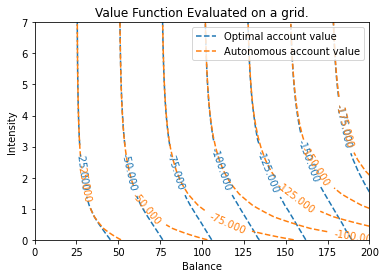

In [119]:
oav = OAV(agent.env.params, agent.env.w0, lmax=7)
oav.solve_v()
fig, ax = oav.plot_vf(plot_aav_flag=True)

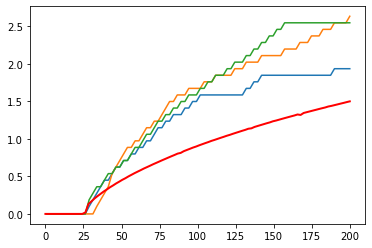

In [120]:
plt.plot(np.array(ws).T, np.array(ls).T)
plt.plot(oav.w_vector, oav.lambdastars, color='red', linewidth=2)

### check the value

In [121]:
rew_ag = evaluate_agent(agent, n=500)
rew_aav = evaluate_agent(agent, n=500, aav=True)

c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[INFO] [2020-07-30 12:30:50,256] [AAV] - Instantiated @ AAV


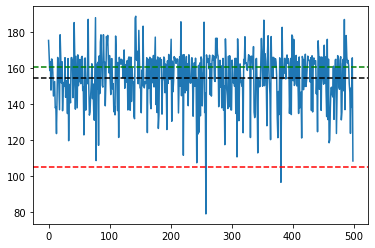

In [126]:
p = agent.env.params
aav = AAV(p)

plt.plot(rew_ag)
plt.axhline(np.mean(rew_ag), color='black', linestyle='--')
plt.axhline(-oav.v(0.11, 200), color='green', linestyle='--')
plt.axhline(np.mean(rew_aav), color='red', linestyle='--')

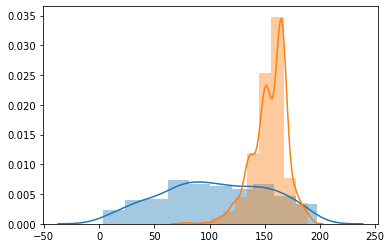

In [127]:
sns.distplot(rew_aav, bins=10)
sns.distplot(rew_ag, bins=10)

In [143]:
print(f"Optimal: {-oav.v(0.11, 200).flatten()[0]}")
print(f"Autonomous: {np.mean(rew_aav)}")
print(f"Learned: {np.mean(rew_ag)}, i.e. {(np.mean(rew_ag)-np.mean(rew_aav))/np.mean(rew_aav) * 100} % over autonomous and {(np.mean(rew_ag)+oav.v(0.11, 200).flatten()[0])/-oav.v(0.11, 200).flatten()[0] * 100} under optimal")

Optimal: 160.72375453212706
Autonomous: 104.99164370126718
Learned: 154.73062227462063, i.e. 47.37422600495313 % over autonomous and -3.7288403789176443 under optimal


## $\kappa=1.4$, $c=10$
Reference parameters from MS paper with 2x kappa -- 3 fully trained policies

In [144]:
ws = []
ls = []
for i, log in enumerate(logs[3:], 3):
    model_path, buffer = construct_paths(i)
    agent = DQNAgent.load(model_path)
    agent.main_net.compile(loss='MSE')
    ww, ll, aa, z = create_map(agent)
    w_front, l_front = get_frontier(ww, ll, aa)
    ws.append(w_front)
    ls.append(l_front)

[WARNING] [2020-07-30 12:37:46,708] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:37:46,806] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:37:54,065] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:37:54,186] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:38:01,139] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:38:01,238] [tensorflow] - No training configuration found in save file: the model was *not* compiled. Compile it manually.
[WARNING] [2020-07-30 12:38:08,737] [tensorflow] - No training configuration found in save file: the model was *

[INFO] [2020-07-30 12:38:14,965] [AAV] - Instantiated @ AAV
[INFO] [2020-07-30 12:38:14,978] [OAV] - Launching the value function procedure.
[INFO] [2020-07-30 12:38:14,978] [OAV] - Computing the value function on (0.00, 63.99].
[INFO] [2020-07-30 12:38:14,993] [OAV] - Computing the value function on (63.99, 71.10].
[INFO] [2020-07-30 12:38:16,651] [OAV] - Computing the value function on (71.10, 79.00].
[INFO] [2020-07-30 12:38:17,975] [OAV] - Computing the value function on (79.00, 87.78].
[INFO] [2020-07-30 12:38:18,905] [OAV] - Computing the value function on (87.78, 97.53].
[INFO] [2020-07-30 12:38:20,087] [OAV] - Computing the value function on (97.53, 108.37].
[INFO] [2020-07-30 12:38:21,221] [OAV] - Computing the value function on (108.37, 120.41].
[INFO] [2020-07-30 12:38:22,514] [OAV] - Computing the value function on (120.41, 133.79].
[INFO] [2020-07-30 12:38:23,942] [OAV] - Computing the value function on (133.79, 148.65].
[INFO] [2020-07-30 12:38:25,495] [OAV] - Computing t

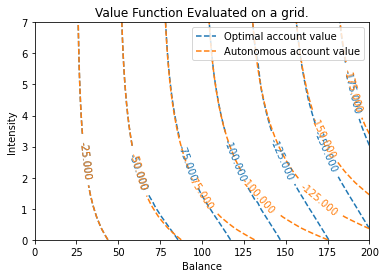

In [145]:
oav_h = OAV(agent.env.params, agent.env.w0, lmax=7)
oav_h.solve_v()
fig, ax = oav_h.plot_vf(plot_aav_flag=True)

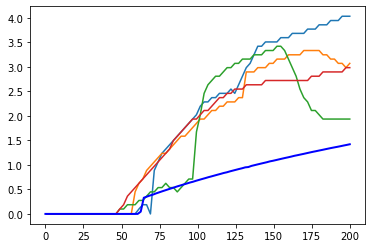

In [146]:
plt.plot(np.array(ws).T, np.array(ls).T)
plt.plot(oav_h.w_vector, oav_h.lambdastars, color='blue', linewidth=2)

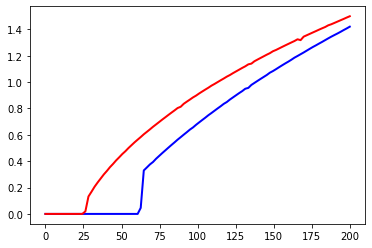

In [147]:
plt.plot(oav_h.w_vector, oav_h.lambdastars, color='blue', linewidth=2)
plt.plot(oav.w_vector, oav.lambdastars, color='red', linewidth=2)

### check the value

In [148]:
rew_ag = evaluate_agent(agent, n=500)
rew_aav = evaluate_agent(agent, n=500, aav=True)

c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[INFO] [2020-07-30 12:39:41,419] [AAV] - Instantiated @ AAV


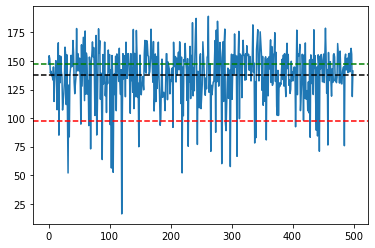

In [149]:
p = agent.env.params
aav = AAV(p)

plt.plot(rew_ag)
plt.axhline(np.mean(rew_ag), color='black', linestyle='--')
plt.axhline(-oav_h.v(0.11, 200), color='green', linestyle='--')
plt.axhline(np.mean(rew_aav), color='red', linestyle='--')

In [150]:
-oav_h.v(0.11, 200)

array([[147.51058615]])

sns.distplot(rew_aav, bins=10)
sns.distplot(rew_ag, bins=10)

In [153]:
print(f"Optimal: {-oav_h.v(0.11, 200).flatten()[0]}")
print(f"Autonomous: {np.mean(rew_aav)}")
print(f"Learned: {np.mean(rew_ag)}, i.e. {(np.mean(rew_ag)-np.mean(rew_aav))/np.mean(rew_aav) * 100} % over autonomous and {(np.mean(rew_ag)+oav_h.v(0.11, 200).flatten()[0])/-oav_h.v(0.11, 200).flatten()[0] * 100} under optimal")

Optimal: 147.5105861452479
Autonomous: 97.68104706051234
Learned: 137.73817679442948, i.e. 41.00808799592636 % over autonomous and -6.624886800460494 under optimal


In [166]:
import os

os.system('jupyter nbconvert --to html explore_learned_policies.ipynb')

0

# ******************* Comments ********************

In [ ]:
import seaborn as sns 
visits = [environment.convert_back(trans.s) for trans in buffer]
visits_w = np.array([vis[1] for vis in visits])
visits_l = np.array([vis[0] for vis in visits])

In [ ]:
sns.distplot(visits_w, bins=10)

In [ ]:
sns.distplot(visits_l, bins=10)

In [ ]:

import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
mask = visits_w > 0

x = visits_w[mask]
y = visits_l[mask]

# fig,ax = plt.subplots(figsize=(10,10))

heatmap, xedges, yedges = np.histogram2d(x, y, bins=(30,20))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower', interpolation='nearest', aspect='auto')
# fig.show()

In [ ]:
np.max(y)

#### lets value this policy:

In [ ]:
agent.main_net.predict_on_batch(environment.observation(np.array([0.11, 200.]))[None, :])

In [ ]:
agent

In [ ]:

rewards = agent.evaluate(2)

In [ ]:
np.mean(rewards)

In [ ]:
from dcc import AAV, Parameters
p = Parameters()
p.c = 10.0
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, MAX_ACCOUNT_BALANCE), color='red', linestyle='--', alpha=0.5)
plt.axhline(-aav.u(4.5, MAX_ACCOUNT_BALANCE) - 4.5*p.c, color='green', linestyle='--')

In [ ]:
p.c

In [ ]:
np.mean(rewards)

In [ ]:
u = -aav.u(0.11, MAX_ACCOUNT_BALANCE)

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
sns.distplot(rewards, ax=ax, bins=10)
sns.distplot(rew_aav, ax=ax, bins=10)
ax.axvline(np.mean(rewards), color='black', linestyle='--')
ax.axvline(np.mean(rew_aav), color='red', linestyle='--')
#ax.axvline(u, color='green', linestyle='--')

In [ ]:
# agent.evaluate(100)

In [ ]:
def sim():
    rewards = []
    w_states = []
    l_states = []
    actions = []
    for i in range(500):
        episode_reward = 0
        done = False
        state = environment.reset()
        while not done:
            # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
            action, q = agent.get_action(state, epsilon=0.0)
            # action = 0
            actions.append(action)
            state, reward, done, _ = environment.step(action)
            episode_reward += reward
            converted_state = environment.convert_back(state)
            w_states.append(converted_state[1])
            l_states.append(converted_state[0])
            if episode_reward>200:
                break
            if done:
                rewards.append(episode_reward)
    return rewards

rew_aav = sim()
        

In [ ]:
#plt.plot(results['REINFORCE AB'])
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rew_aav)
plt.axhline(np.mean(rew_aav), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')

In [ ]:
import seaborn as sns
fig, ax = plt.subplots()
# sns.distplot(rewards, ax=ax, bins=10)
sns.distplot(rew_aav, ax=ax, bins=10)
# ax.axvline(np.mean(rewards), color='black', linestyle='--')
ax.axvline(np.mean(rew_aav), color='red', linestyle='--')

Statespace path

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        # action = np.argmax(agent.main_net.predict_on_batch(state[None,:]))
        action, q = agent.get_action(state, epsilon=0.0)
        #action = 0
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if episode_reward>200:
            break
        if done:
            rewards.append(episode_reward)


In [ ]:
l_states[0]

In [ ]:
fig, ax = plt.subplots()
ax.plot(w_states, l_states, marker='x')
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')

In [ ]:
 environment.reset()

In [ ]:
fig, ax = plt.subplots()
ax.plot(actions, marker='x')
ax.set_xlabel('steps')
ax.set_ylabel('Action size applied')

In [ ]:
plt.plot(rewards)

Test policy that separates linearly the statespace by y=x

In [ ]:
def dummy_policy(state):
    if state[1] > state[0]:
        return 0
    else:
        return 1

In [ ]:
rewards = []
w_states = []
l_states = []
actions = []
for i in range(1000):
    episode_reward = 0
    done = False
    state = environment.reset()
    while not done:
        action = dummy_policy(state)
        actions.append(action)
        state, reward, done, _ = environment.step(action)
        episode_reward += reward
        converted_state = environment.convert_back(state)
        w_states.append(converted_state[1])
        l_states.append(converted_state[0])
        if done:
            rewards.append(episode_reward)

In [ ]:
from dcc import AAV, Parameters
p = Parameters()
aav = AAV(p)

plt.plot(rewards)
plt.axhline(np.mean(rewards), color='black', linestyle='--')
plt.axhline(-aav.u(0.11, 100), color='red', linestyle='--')